# Topic Clustering using Sentence Embeddings

In [38]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pickle
from itertools import zip_longest, chain, product, islice
from functools import partial
import gc
import numpy as np
import pandas as pd
import re
import json
sys.path.append("/home/piotr/projects/twitter/src")
from twitter_tools.utils import read_files, clean_tweets
from twitter_models.embeddings import KTopicModel
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from gensim.models.ldamulticore import LdaModel
from gensim.models import KeyedVectors
from gensim.corpora.dictionary import Dictionary
from nltk import FreqDist, word_tokenize



sys.path.append("/home/piotr/projects/twitter/src")
from twitter_tools.utils import read_files, clean_tweets
from twitter_models.embeddings import KTopicModel



from tqdm.notebook import tqdm
tqdm.pandas()

path_clean = "/home/piotr/projects/twitter/data/clean" #data path for reader
path_results = "/home/piotr/projects/twitter/notebooks/nlp/results/topics" #path for results
nonpolish_ids = json.load(open(os.path.join(path_clean, "non_polish_ids.json"), "r"))

### Define topic modelling evaluation methods:

Tokens not appearing as most common in other topics:

In [2]:
def eval_topics(text, labels, n = 100):
    dists = dict()
    for i in np.unique(labels):
        txt = text[labels == i]
        freq = FreqDist(chain.from_iterable(txt))
        dists[i] = freq.most_common(n)
    dists_unique = dict()
    for i, dist in dists.items():
        #get vocabulary of all other topics but i
        rest = []
        _ = [rest.extend([el[0] for el in v]) for k, v in dists.items() if k != i]
        #filter out those not included in the vocabulary of topic i
        dists_unique[i] = {k:v for k, v in dist if k not in rest}
    return dists_unique

In [3]:
def clustering_summary(text, labels, source, **kwargs):
    dists = eval_topics(text, labels, **kwargs)
    dists_nocounts = {k:[", ".join(list(v))] for k, v in dists.items()}
    df =  pd.DataFrame.from_dict(dists_nocounts, orient = "index")
    sources = pd.crosstab(labels, source)
    df = pd.merge(df, sources, left_index = True, right_index = True)
    df["count"] = df[["gov","opp"]].sum(axis = 1)
    df.columns = ["tokens","gov","opp","count"]
    return df, dists

In [36]:
def data_filter(data, n, stopwords = None):
    if not stopwords:
        stopwords = []
    data.loc[:,("lemmatized")] = data.loc[:,("lemmatized")].apply(lambda x: [word for word in x.split() if word not in stopwords])
    data = data[data.lemmatized.apply(lambda x: len(x) >= n)] #longer than n
    data.loc[:,("lemmatized")] = data.loc[:,("lemmatized")].apply(lambda x: " ".join(x))
    data[data["user-id_str"].apply(lambda x: x not in nonpolish_ids)] #exclude non-polish users
    data = data.loc[data.polish > 0.5] #more than 50% polish words
    data = data[data.lemmatized.apply(lambda x: len(x) >= n)] #longer than n
    data = data[np.logical_not(data.retweet)]
    return data

### K-Means Clustering of sentence embeddings, as defined in [A Simple But Though-to-Beat Baseline for Sentence Embbedings](https://openreview.net/pdf?id=SyK00v5xx)

In [29]:
res = pickle.load(open(os.path.join(path_results, "results.p"), "rb"))
res = [elem for elem in res if "fit" in elem.keys()]
_  = [elem.update(elem.pop("fit")) for elem in res]
pd.DataFrame(res)

,min_length,a,k,silhuette,intertia
0,10,0.01000,5,-0.172491,5389.128331
1,10,0.01000,10,0.021512,5347.520719
2,10,0.01000,20,0.070773,5340.289891
3,10,0.00100,5,0.086591,5360.123096
4,10,0.00100,10,0.131579,5376.574619
5,10,0.00100,20,0.120643,5341.168861
6,10,0.00001,5,0.999472,5349.764723
7,10,0.00001,10,0.025021,5340.517457
8,10,0.00001,20,0.076038,5357.850270
9,5,0.01000,5,0.998604,25617.524550


Load the best clustering:

In [79]:
data = pd.DataFrame()
for dat in tqdm(read_files(path_clean, 84, filter_fun = partial(data_filter, n = 5))):
    data = data.append(dat[["full_text", "id_str","user-id_str", "source", "lemmatized"]])
cls = json.load(open(os.path.join(path_results, 'cluster_k_5_n_5_a_0.001.json')))
data["cluster"] = data["full_text"].map(cls)

In [77]:
vocab = chain.from_iterable([elem.split() for elem in data["tokenized"][data["cluster"] == 1.0].tolist()])
fd = FreqDist(vocab)

In [78]:
fd.most_common(10)

[('na', 57769),
 ('to', 54028),
 ('nie', 42743),
 ('się', 39388),
 ('że', 28180),
 ('do', 24584),
 ('jest', 22297),
 ('jak', 19718),
 ('co', 15352),
 ('po', 12470)]

In [42]:

df, dists = clustering_summary(data.dropna(subset = ["cluster"]).full_text.apply(lambda x: x.split()), 
                          data.dropna(subset = ["cluster"]).cluster.astype(int),
                       data.dropna(subset = ["cluster"]).source)

In [15]:
file = "topics_model_k10_d85_sample"
if os.path.isfile(os.path.join("results_new", file + ".p")):
    model_topics = pickle.load(open(os.path.join("results_new", file + ".p"),"rb"))
    summary = pd.read_csv(os.path.join("results_new", file + ".csv"))
else:
    model_topics = KTopicsModel(k = 10, path_embeddings = "/home/piotr/nlp/cc.pl.300.vec", dask_split = 200)
    model_topics.fit(text)
    pickle.dump(model_topics, open(os.path.join("results_new", file + ".p"),"wb"))
    summary = clustering_summary(text[model_topics.keepind], model_topics.labels, source[model_topics.keepind])
    summary.to_csv(os.path.join("results_new", file + ".csv"))

#### Distribution of the topics

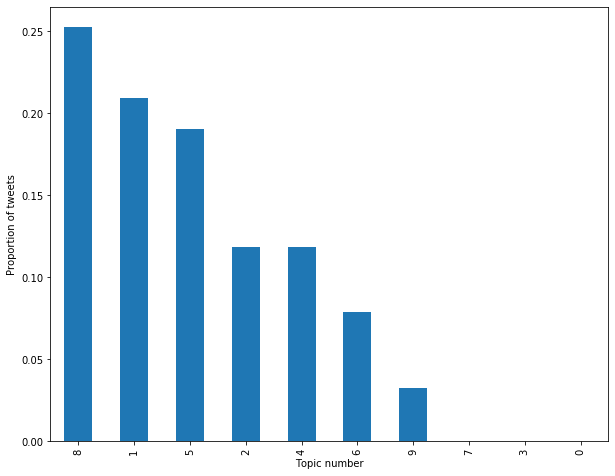

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
pd.value_counts(data.cluster, normalize = True).plot.bar(ax = ax)
ax.set_xlabel("Topic number")
ax.set_ylabel("Proportion of tweets")
plt.show()

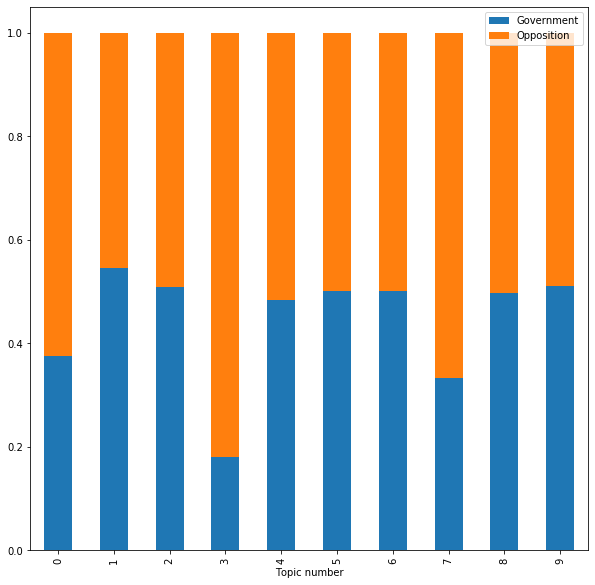

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
pd.crosstab(data.cluster, data.source, normalize = "index").plot.bar(ax = ax, stacked = True)
ax.set_xlabel("Topic number")
ax.legend(["Government", "Opposition"])
plt.show()

#### Most common "unique" tokens in each topic:

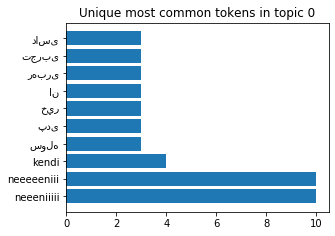

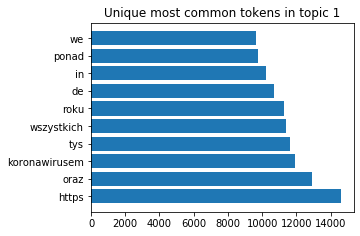

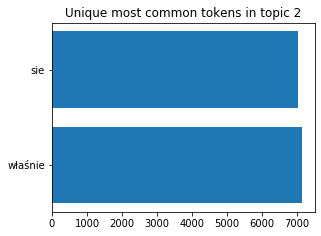

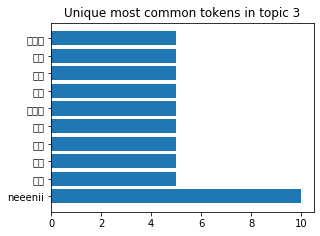

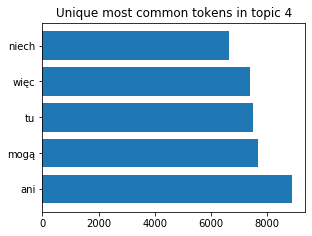

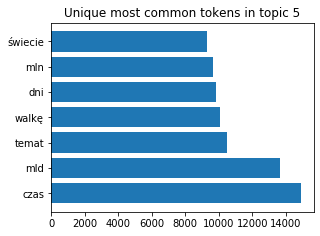

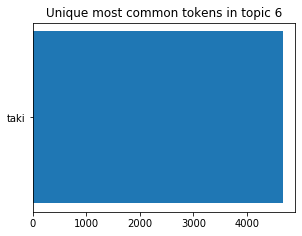

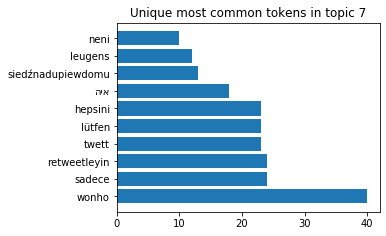

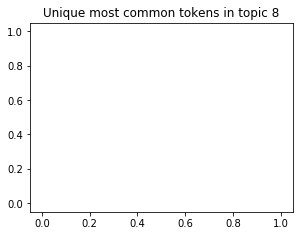

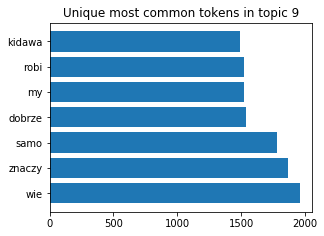

In [62]:
for i, (k, fdist) in enumerate(dists.items()):
    fig = plt.figure(figsize = (16, 16))
    ax = fig.add_subplot(4, 3, i + 1)
    ax.set_title(f"Unique most common tokens in topic {k}")
    ax.barh(y = list(fdist.keys())[:10], width = list(fdist.values())[:10])
plt.show()

### Latent Dirchlet Allocation

In [ ]:
if os.path.isfile("results/lda_k10_d85.p"):
    lda = pickle.load(open("results/lda_k10_d85.p","rb"))
    tweet_dictionary = Dictionary(data.full_text.tolist())
    tweets_corp = [tweet_dictionary.doc2bow(tweet) for tweet in data.full_text.tolist()]
else:
    tweet_dictionary = Dictionary(text)
    tweets_corp = [tweet_dictionary.doc2bow(tweet) for tweet in data.full_text.tolist()]
    lda = LdaModel(tweets_corp, num_topics = 10, id2word = tweet_dictionary)
    pickle.dump(lda, open("results/lda_k10_d85.p","wb"))

In [ ]:
topics = np.array([tweet[max(range(len(tweet)), key = lambda i: tweet[i][1])][0] for tweet in tqdm(lda[tweets_corp])])

#### Distribution of the topics:

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
pd.value_counts(topics, normalize = True).plot.bar(ax = ax)
ax.set_xlabel("Topic number")
ax.set_ylabel("Proportion of tweets")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
pd.crosstab(topics, source, normalize = True).plot.bar(ax = ax, stacked = True)
ax.set_xlabel("Topic number")
ax.legend(["Government", "Opposition"])
plt.show()

#### Most common "unique" tokens in each topic:

In [ ]:
dists = eval_topics(text, topics)
for i, (k, fdist) in enumerate(dists.items()):
    fig = plt.figure(figsize = (16, 16))
    ax = fig.add_subplot(4, 3, i + 1)
    ax.set_title(f"Unique most common tokens in topic {k}")
    ax.barh(y = list(fdist.keys())[:10], width = list(fdist.values())[:10])
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
korona_counts = np.array([set(w).intersection(topic_vocab["wirus"]) != set() for w in text])
pd.crosstab(topics, korona_counts, normalize = "index").plot.bar(ax = ax, stacked = True)
ax.set_xlabel("Topic number")
ax.legend(title = "Contains koronawirus?")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
wybory_counts = np.array([set(w).intersection(topic_vocab["wybory"]) != set() for w in text])
pd.crosstab(topics, wybory_counts, normalize = "index").plot.bar(ax = ax, stacked = True)
ax.legend(title = "Contains election vocabulary?")
ax.set_xlabel("Topic number")
plt.show()